In [2]:
import pandas as pd
import os
import numpy as np
from scipy import stats

from abag_affinity.utils.config import read_yaml, get_data_paths, get_resources_paths

In [3]:
config = read_yaml("../abag_affinity/config.yaml")

skempi_summary_path, _ = get_resources_paths(config, "SKEMPI.v2")
skempi_summary_df = pd.read_csv(skempi_summary_path, sep=";")
skempi_summary_df["pdb_id"] = skempi_summary_df["#Pdb"].apply(lambda val: val.split("_")[0]) 
skempi_summary_df["mutation_code"] = skempi_summary_df["Mutation(s)_cleaned"]

In [4]:
skempi_scores_path, _ = get_data_paths(config, "SKEMPI.v2")
skempi_scores_df = pd.read_csv(skempi_scores_path)

In [5]:
skempi_merged = pd.merge(skempi_summary_df, skempi_scores_df, on=['pdb_id', 'mutation_code'], how='inner')

#### Define helper functions

In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


def get_best_correlation(df, measured_affinity_column, predicted_affinity_columns):
    correlations = {}
    for col in predicted_affinity_columns:
        # remove outiers 
        # outliers have a zscroe above 3
        mask = np.abs(stats.zscore(df[col])) < 3

        correlations[col] = df[col][mask].corr(df[measured_affinity_column][mask].astype(float))
    best_combi = ()
    best_correlation = -1

    for measure in correlations.keys():
        if correlations[measure] > best_correlation:
            best_correlation = correlations[measure]
            best_combi = (measured_affinity_column, measure)
                
    return best_combi, best_correlation


def plot_correlation(df, best_combi):
    mask = np.abs(stats.zscore(df[best_combi[1]])) < 3
    masked_df = df[mask]

    masked_df.plot.scatter(best_combi[0], best_combi[1])
    #plt.ylim([-13,-10])
    try:

        m, b = np.polyfit(masked_df[best_combi[0]], masked_df[best_combi[1]], 1)

        plt.plot(masked_df[best_combi[0]], m*masked_df[best_combi[0]] + b)
    except:
        print("SVD did not converge")
    

In [7]:
import numpy as np

gas_constant =  8.31446261815324 # 0.0821 kcal

def calc_delta_g(row, affinity_col):
    temperature = row["Temperature_cleaned"]
    affinity = row[affinity_col]
    delta_g = gas_constant * temperature * np.log(affinity)
    return delta_g / 4184 # convert to kcal

def clean_temp(value):
    value = value.replace("(assumed)", "")
    try:
        return int(value)
    except:
        return np.nan
            

In [8]:
skempi_merged["Temperature_cleaned"] = skempi_merged["Temperature"].apply(lambda val: clean_temp(val))

In [9]:
skempi_merged["delta_g_wt"] = skempi_merged.apply(lambda row: calc_delta_g(row,"Affinity_wt_parsed"), axis=1)
skempi_merged["delta_g_mut"] = skempi_merged.apply(lambda row: calc_delta_g(row,"Affinity_mut_parsed"), axis=1)

## Compare absolut energy values with Rosetta prediction

In [37]:
best_combi, best_correlation = get_best_correlation(skempi_merged, "delta_g_wt", ["wildtype", "relaxed_wildtype"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g_wt and wildtype of -0.07652538079927096


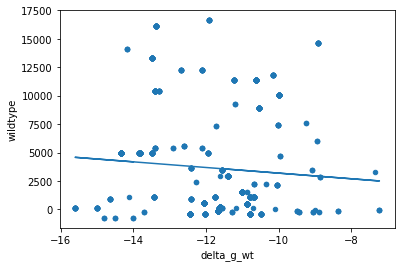

In [38]:
plot_correlation(skempi_merged, best_combi)

In [39]:
best_combi, best_correlation = get_best_correlation(skempi_merged, "delta_g_mut", ["mutated_wildtype", "relaxed_mutated", "relaxed_mutated_relaxed"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g_mut and relaxed_mutated_relaxed of 0.02827168851008513


SVD did not converge

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


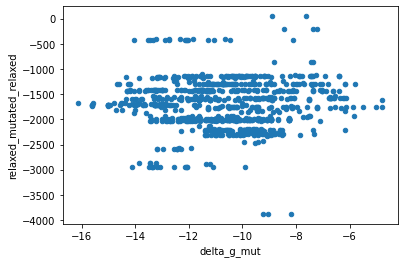

In [40]:
plot_correlation(skempi_merged, best_combi)

## Compare change in affinity with Rosetta predictions

In [41]:
skempi_merged["affinity_change"] = skempi_merged["delta_g_wt"] - skempi_merged["delta_g_mut"]

In [49]:
best_combi, best_correlation = get_best_correlation(skempi_merged, "affinity_change", ["wildtype vs mutated_wildtype", "wildtype vs mutated_relaxed", "relaxed_wildtype vs relaxed_mutated", "relaxed_wildtype vs relaxed_mutated_relaxed"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between affinity_change and wildtype vs mutated_relaxed of 0.10036571266197278


SVD did not converge

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


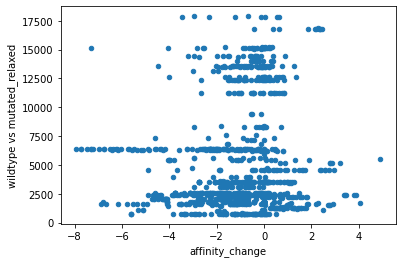

In [50]:
plot_correlation(skempi_merged, best_combi)
#plt.xlim([-0.000005, 0])